# Grain Classification Challenge
***

This notebook provides a complete implementation for the Grain AI Challenge. The task involves classifying grain images by variety using RGB image data.

## Challenge Overview
- **Task**: Multi-class classification of grain varieties from RGB images
- **Data**: RGB images stored in .npz format with metadata in filenames
- **Model**: Convolutional Neural Network (CNN) for image classification
- **Evaluation**: Accuracy and other classification metrics

## Model Weights
Pre-trained model weights are available on Hugging Face:
- **Model Repository**: [https://huggingface.co/moujar/Grain](https://huggingface.co/moujar/Grain)

## Data Structure
- Each .npz file contains:
  - `x`: RGB image array (H, W, 3)
  - `y`: Label/target value
- Filenames contain metadata: grainID, varietyNumber, microplotID, timestamp

⚠️ NOTE: All sections are fully implemented with detailed code for data loading, visualization, training, and scoring.

***

`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [ ]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/M1-AI-Challenge-Class-2025-26.git
    # move to the starting kit folder
    %cd M1-AI-Challenge-Class-2025-26/Starting_Kit/

# 0 - Imports & Settings

In [2]:
!pip install torch torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e7/69/30f5f03752aa1a7c23931d2519b31e557f3f10af5089d787cddf3b903ecf/torchvision-0.24.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.4 MB/s eta 0:00:00m eta 0:00:010:00:01


In [2]:
import os
import zipfile
import datetime
import re
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
%matplotlib inline

# 1 - Data
This section implements data loading and preprocessing for grain RGB images.

The Data class:
- Loads .npz files containing RGB images and labels
- Extracts metadata from filenames
- Applies brightness correction (Spectralon normalization)
- Prepares train/validation/test splits
- Creates PyTorch datasets and dataloaders

In [3]:
class GrainDataset(Dataset):
    """PyTorch Dataset for grain images"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to tensor and normalize
        if self.transform:
            image = self.transform(image)
        else:
            # Default: convert to tensor and normalize to [0, 1]
            image = torch.FloatTensor(image).permute(2, 0, 1) / 255.0
        
        return image, torch.LongTensor([label])[0]


class Data:
    def __init__(self, data_dir, test_size=0.2, val_size=0.1, random_state=42):
        self.data_dir = data_dir
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.files = []
        self.images = []
        self.labels = []
        self.metadata = []
        self.label_encoder = LabelEncoder()
        
    def load_and_clean_files(self, files_dir):
        """Load and clean file list"""
        files = os.listdir(files_dir)
        if ".DS_Store" in files:
            files.remove(".DS_Store")
        return [f for f in files if f.endswith('.npz')]
    
    def extract_metadata(self, filename):
        """Extract metadata from filename"""
        grain_match = re.search(r"grain(?P<grainID>\d+)", filename)
        var_match = re.search(r"var(?P<varietyNumber>\d+)", filename)
        micro_match = re.search(r"x(?P<x>\d+)y(?P<y>\d+)", filename)
        time_match = re.search(
            r"2x_(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<timestamp>\d+)_corr",
            filename
        )
        
        if not all([grain_match, var_match, micro_match, time_match]):
            return None
        
        return {
            "grainID": grain_match.group("grainID"),
            "varietyNumber": var_match.group("varietyNumber"),
            "microplotID": f"x{micro_match.group('x')}y{micro_match.group('y')}",
            "year": time_match.group("year"),
            "month": time_match.group("month"),
            "day": time_match.group("day"),
            "timestamp": time_match.group("timestamp"),
            "filename": filename
        }
    
    def band_brightness_npz(self, cube, k):
        """Approximation of the original Spectralon normalization"""
        band = cube[:, :, k]
        return np.mean(band) if np.mean(band) != 0 else 1.0
    
    def preprocess_image(self, img):
        """Apply brightness correction and normalization"""
        # Apply per-band brightness correction
        r = img[:, :, 0] / self.band_brightness_npz(img, 0)
        g = img[:, :, 1] / self.band_brightness_npz(img, 1)
        b = img[:, :, 2] / self.band_brightness_npz(img, 2)
        img = np.dstack((b, g, r))
        
        # Normalize per image
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img_norm = (img - vmin) / (vmax - vmin) * 255.0
        else:
            img_norm = np.zeros_like(img)
        
        return img_norm.astype(np.uint8)
    
    def load_data(self):
        """Load all data files and extract images/labels"""
        print(f"Loading data from {self.data_dir}...")
        self.files = self.load_and_clean_files(self.data_dir)
        print(f"Found {len(self.files)} files")
        
        # Load images and labels
        for filename in self.files:
            try:
                data = np.load(os.path.join(self.data_dir, filename))
                img = data["x"]
                label = data["y"]
                
                # Preprocess image
                img_processed = self.preprocess_image(img)
                
                self.images.append(img_processed)
                self.labels.append(int(label))
                
                # Extract metadata
                meta = self.extract_metadata(filename)
                if meta:
                    self.metadata.append(meta)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
        
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
        
        print(f"Loaded {len(self.images)} images")
        print(f"Number of classes: {len(np.unique(self.labels))}")
        print(f"Class distribution: {np.bincount(self.labels)}")
        
        return self.images, self.labels
    
    def get_splits(self):
        """Create train/validation/test splits"""
        if len(self.images) == 0:
            self.load_data()
        
        # First split: train+val vs test
        X_temp, X_test, y_temp, y_test = train_test_split(
            self.images, self.labels,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=self.labels
        )
        
        # Second split: train vs val
        val_size_adjusted = self.val_size / (1 - self.test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            random_state=self.random_state,
            stratify=y_temp
        )
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def get_dataloaders(self, batch_size=32, num_workers=0):
        """Get PyTorch dataloaders for train/val/test"""
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = self.get_splits()
        
        # Create datasets
        train_dataset = GrainDataset(X_train, y_train)
        val_dataset = GrainDataset(X_val, y_val)
        test_dataset = GrainDataset(X_test, y_test)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        return train_loader, val_loader, test_loader

NameError: name 'Dataset' is not defined

In [17]:
# Example usage
# Note: Update data_dir to point to your actual data directory
data = Data(data_dir="../Data/Grain-Data-RGB")
data.load_data()
train_loader, val_loader, test_loader = data.get_dataloaders(batch_size=32)

Loading data from ../Data/Grain-Data-RGB...
Found 26882 files
Loaded 26882 images
Number of classes: 8
Class distribution: [   0 3462 3933 3434 3205 3031 3201 3115 3501]


# 2 - Visualization
This section implements visualization functions for grain images.

The Visualize class:
- Plots random samples from the dataset
- Displays images with their labels
- Shows class distribution
- Visualizes training progress (loss and accuracy curves)

In [18]:
class Visualize:
    def __init__(self, data: Data):
        self.data = data
    
    def plot_random_samples(self, n_samples=20, cols=5):
        """Plot random samples from the dataset"""
        if len(self.data.images) == 0:
            self.data.load_data()
        
        indices = random.sample(range(len(self.data.images)), min(n_samples, len(self.data.images)))
        rows = math.ceil(n_samples / cols)
        
        plt.figure(figsize=(cols * 2.0, rows * 2.0))
        
        for i, idx in enumerate(indices):
            img = self.data.images[idx]
            label = self.data.labels[idx]
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img.astype(np.uint8))
            plt.title(f"Label: {label}", fontsize=10)
            plt.axis("off")
        
        plt.tight_layout(pad=0.5)
        plt.show()
    
    def plot_class_distribution(self):
        """Plot the distribution of classes"""
        if len(self.data.labels) == 0:
            self.data.load_data()
        
        unique, counts = np.unique(self.data.labels, return_counts=True)
        
        plt.figure(figsize=(10, 6))
        plt.bar(unique, counts)
        plt.xlabel("Class (Variety Number)")
        plt.ylabel("Number of Samples")
        plt.title("Class Distribution")
        plt.grid(axis='y', alpha=0.3)
        plt.show()
        
        print(f"Total samples: {len(self.data.labels)}")
        print(f"Number of classes: {len(unique)}")
        print(f"Class distribution: {dict(zip(unique, counts))}")
    
    def plot_training_history(self, history):
        """Plot training and validation loss/accuracy curves"""
        if 'train_loss' not in history:
            print("No training history available")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss
        ax1.plot(history['train_loss'], label='Train Loss')
        if 'val_loss' in history:
            ax1.plot(history['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Plot accuracy
        if 'train_acc' in history:
            ax2.plot(history['train_acc'], label='Train Accuracy')
        if 'val_acc' in history:
            ax2.plot(history['val_acc'], label='Val Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_data(self):
        """Main visualization function"""
        self.plot_class_distribution()
        self.plot_random_samples()

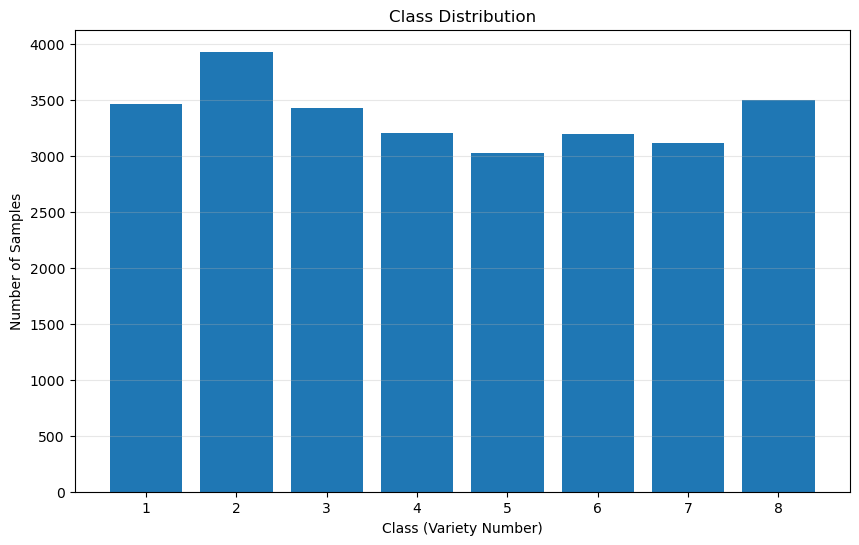

Total samples: 26882
Number of classes: 8
Class distribution: {1: 3462, 2: 3933, 3: 3434, 4: 3205, 5: 3031, 6: 3201, 7: 3115, 8: 3501}


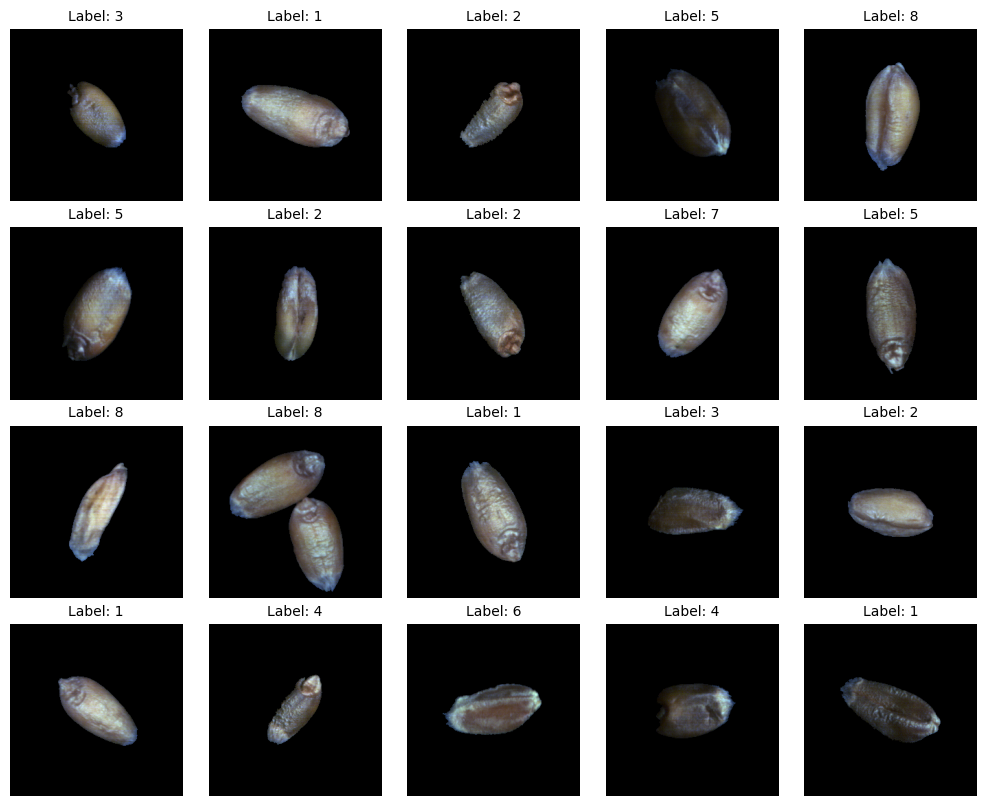

In [24]:
# Example usage
visualize = Visualize(data=data)
visualize.plot_data()

# 3 - Training
This section implements model training for grain variety classification.

The Train class:
- Defines a CNN architecture for image classification
- Implements training loop with validation
- Saves model checkpoints
- Tracks training history (loss and accuracy)
- Supports early stopping and learning rate scheduling 

In [20]:
class GrainCNN(nn.Module):
    """CNN model for grain classification"""
    def __init__(self, num_classes=10, input_channels=3):
        super(GrainCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling for variable input sizes
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Convolutional layers with batch norm and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        # Adaptive pooling to ensure consistent size
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x


class Train:
    def __init__(self, data: Data, num_classes=None, device=None, model_path=None):
        self.data = data
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        # Determine number of classes
        if num_classes is None:
            if len(self.data.labels) > 0:
                num_classes = len(np.unique(self.data.labels))
            else:
                num_classes = 10  # Default
        
        self.num_classes = num_classes
        self.model_path = model_path
        
        print(f"Using device: {self.device}")
        print(f"Number of classes: {self.num_classes}")
    
    def create_model(self):
        """Create and initialize the model"""
        self.model = GrainCNN(num_classes=self.num_classes).to(self.device)
        return self.model
    
    def train_epoch(self, train_loader, criterion, optimizer):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader, criterion):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def train(self, epochs=10, batch_size=32, learning_rate=0.001, 
              early_stopping_patience=5, save_best=True):
        """Main training function"""
        # Get dataloaders
        train_loader, val_loader, _ = self.data.get_dataloaders(batch_size=batch_size)
        
        # Create model if not exists
        if self.model is None:
            self.create_model()
        
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        print("Starting training...")
        for epoch in range(epochs):
            # Train
            train_loss, train_acc = self.train_epoch(train_loader, criterion, optimizer)
            
            # Validate
            val_loss, val_acc = self.validate(val_loader, criterion)
            
            # Update learning rate
            scheduler.step(val_loss)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            # Print progress
            print(f"Epoch [{epoch+1}/{epochs}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
            
            # Early stopping and model saving
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                if save_best and self.model_path:
                    self.save_model(self.model_path)
                    print(f"  Saved best model (val_loss: {val_loss:.4f})")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        print("Training completed!")
        return self.history
    
    def save_model(self, path):
        """Save model checkpoint"""
        os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'num_classes': self.num_classes,
            'history': self.history
        }, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=self.device)
        if self.model is None:
            self.num_classes = checkpoint.get('num_classes', self.num_classes)
            self.create_model()
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.history = checkpoint.get('history', self.history)
        print(f"Model loaded from {path}")

In [ ]:
# Example usage
train = Train(data=data, model_path="./models/grain_model.pth")
history = train.train(epochs=20, batch_size=32, learning_rate=0.001)

# 4 - Scoring
This section implements model evaluation and scoring.

The Score class:
- Evaluates model on test set
- Computes accuracy, precision, recall, and F1-score
- Generates confusion matrix
- Provides per-class metrics 

In [22]:
class Score:
    def __init__(self, model, data: Data, device=None):
        self.model = model
        self.data = data
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.score = None
        self.predictions = None
        self.true_labels = None
    
    def evaluate(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            _, _, test_loader = self.data.get_dataloaders(batch_size=32)
        
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        self.predictions = np.array(all_preds)
        self.true_labels = np.array(all_labels)
        
        return self.predictions, self.true_labels
    
    def compute_accuracy(self):
        """Compute overall accuracy"""
        if self.predictions is None:
            self.evaluate()
        
        accuracy = np.mean(self.predictions == self.true_labels)
        return accuracy
    
    def compute_classification_metrics(self):
        """Compute precision, recall, F1-score per class"""
        
        if self.predictions is None:
            self.evaluate()
        
        precision, recall, f1, support = precision_recall_fscore_support(
            self.true_labels, self.predictions, average=None, zero_division=0
        )
        
        # Overall metrics (macro average)
        macro_precision = np.mean(precision)
        macro_recall = np.mean(recall)
        macro_f1 = np.mean(f1)
        
        # Weighted average
        weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
            self.true_labels, self.predictions, average='weighted', zero_division=0
        )
        
        metrics = {
            'per_class': {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': support
            },
            'macro': {
                'precision': macro_precision,
                'recall': macro_recall,
                'f1': macro_f1
            },
            'weighted': {
                'precision': weighted_precision,
                'recall': weighted_recall,
                'f1': weighted_f1
            }
        }
        
        # Print classification report
        print(classification_report(self.true_labels, self.predictions))
        
        return metrics
    
    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        
        if self.predictions is None:
            self.evaluate()
        
        cm = confusion_matrix(self.true_labels, self.predictions)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    def compute_score(self):
        """Main scoring function - computes all metrics"""
        print("Evaluating model...")
        self.evaluate()
        
        accuracy = self.compute_accuracy()
        print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        metrics = self.compute_classification_metrics()
        
        self.score = {
            'accuracy': accuracy,
            'metrics': metrics
        }
        
        self.plot_confusion_matrix()
        
        return self.score

In [ ]:
score = Score(model=train.model, data=data)
results = score.compute_score()

# 5 - (Optional) Prepare submission for Codabench

***

In this section you should prepare a zip of the trained model (if your competition is a code submission competition) or zip of the predictions (if your competition is a result submission competition). 

***

In [ ]:
class Submission:
    def __init__(self, submission_dir, zip_file_name):
        self.submission_dir = submission_dir
        self.zip_file_name = zip_file_name

        os.makedirs(self.submission_dir, exist_ok=True)

    def save_code(self, model, model_name="grain_model.pth", additional_files=None):
        """Save trained model to submissions directory"""
        # Save model
        model_path = os.path.join(self.submission_dir, model_name)
        if isinstance(model, nn.Module):
            torch.save(model.state_dict(), model_path)
            print(f"Model saved to {model_path}")
        else:
            # If it's already a path, copy it
            import shutil
            if os.path.exists(model):
                shutil.copy(model, model_path)
                print(f"Model copied to {model_path}")
        
        # Save additional files if provided
        if additional_files:
            for file_path in additional_files:
                if os.path.exists(file_path):
                    filename = os.path.basename(file_path)
                    dest_path = os.path.join(self.submission_dir, filename)
                    shutil.copy(file_path, dest_path)
                    print(f"Copied {filename} to submission directory")

    def save_result(self, predictions, true_labels=None, filename="predictions.npy"):
        """Save predictions to submissions directory"""
        predictions_path = os.path.join(self.submission_dir, filename)
        np.save(predictions_path, predictions)
        print(f"Predictions saved to {predictions_path}")
        
        if true_labels is not None:
            labels_path = os.path.join(self.submission_dir, "true_labels.npy")
            np.save(labels_path, true_labels)
            print(f"True labels saved to {labels_path}")
        
        # Also save as CSV if 1D array
        if predictions.ndim == 1:
            csv_path = os.path.join(self.submission_dir, "predictions.csv")
            pd.DataFrame({'predictions': predictions}).to_csv(csv_path, index=False)
            print(f"Predictions saved to {csv_path}")
        
    def zip_submission(self):
        """Create ZIP file of submission directory"""
        # Path to ZIP
        zip_path = os.path.join(self.submission_dir, self.zip_file_name)

        # Create ZIP containing the submission directory files
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            for filename in os.listdir(self.submission_dir):
                file_path = os.path.join(self.submission_dir, filename)

                # Skip the zip file itself
                if file_path == zip_path:
                    continue

                zf.write(file_path, arcname=filename)
        print(f"Submission ZIP saved at: {zip_path}")
        return zip_path

In [ ]:
Example usage
zip_file_name = f"Submission_{datetime.datetime.now().strftime('%y-%m-%d-%H-%M')}.zip"

submission = Submission(
    submission_dir="./submission",
    zip_file_name=zip_file_name
)

# Save model (code submission)
submission.save_code(model=train.model, model_name="grain_model.pth")

# OR save predictions (result submission)
# submission.save_result(predictions=score.predictions, true_labels=score.true_labels)

# Zip submission dir
submission.zip_submission()

Submission ZIP saved at: submissions/Submission_25-08-26-21-47.zip
